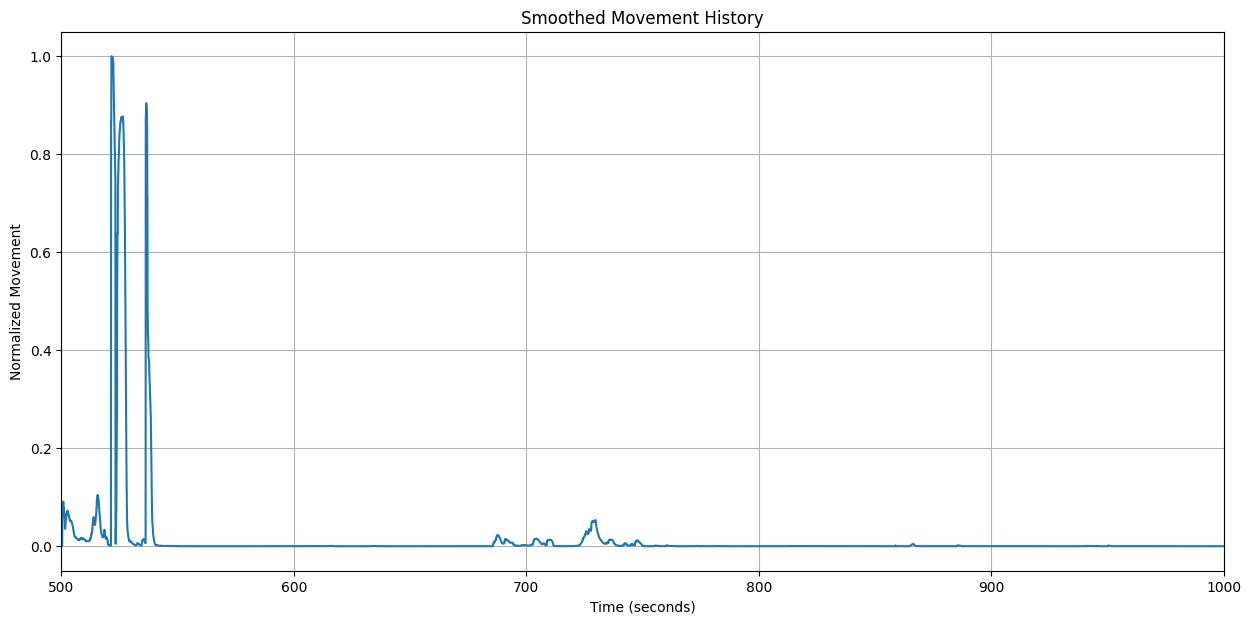

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import medfilt

def generate_movement_chart(video_path, interval, fps, polygon_points):
    # Open the video
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error: Could not open video.")
        return

    # Initialize the background subtractor
    fgbg = cv2.createBackgroundSubtractorMOG2(history=500, varThreshold=50, detectShadows=False)

    # Initialize variables for motion detection
    movement_history = []

    # Calculate start and end frames
    start_time, end_time = interval
    start_frame = int(start_time * fps)
    end_frame = int(end_time * fps)

    # Create the polygon mask
    _, frame = cap.read()
    height, width = frame.shape[:2]
    polygon_mask = np.zeros((height, width), dtype=np.uint8)
    cv2.fillPoly(polygon_mask, [polygon_points], 255)

    # Set the start frame
    cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

    # Process the specified video segment to calculate movement coefficients
    while cap.get(cv2.CAP_PROP_POS_FRAMES) < end_frame:
        ret, frame = cap.read()
        if not ret:
            break

        # Convert to grayscale
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Apply the background subtractor to get the foreground mask
        fgmask = fgbg.apply(gray)

        # Ensure mask and frame have the same size
        fgmask_resized = cv2.resize(fgmask, (width, height))

        # Apply the polygon mask to the foreground mask
        masked_fg = cv2.bitwise_and(fgmask_resized, fgmask_resized, mask=polygon_mask)

        # Calculate the sum of absolute differences in the masked foreground
        movement = np.sum(masked_fg > 0)
        movement_history.append(movement)

    # Close the video file
    cap.release()

    # Apply median filtering for smoothing with a kernel size of 5
    smoothed_movement = medfilt(movement_history, kernel_size=5)

    # Normalize the movement for visualization
    smoothed_movement = smoothed_movement / np.max(smoothed_movement)

    # Create and display the plot
    plt.figure(figsize=(15, 7))
    time_axis = np.linspace(start_time, end_time, num=len(smoothed_movement))
    plt.plot(time_axis, smoothed_movement)
    plt.title('Smoothed Movement History')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Normalized Movement')
    plt.grid(True)
    plt.xlim(start_time, end_time)
    plt.show()

# Define the polygon for the mask with the appropriate dimensions
height, width = 720, 1280  # Example dimensions, adjust as needed
polygon_points = np.array([[(width//2.5, height//12),
                            (1.5*width//2.5, height//12),
                            (3*width//4, 3*height//4),
                            (width//4, 3*height//4)]], dtype=np.int32)

# Define video path and fps
video_path = '/content/drive/MyDrive/medical-data/room1.mp4'
fps = 30  # Adjust based on your video

# Define the start and end interval in seconds
interval = [500, 1000]  # Example interval, can be changed

# Generate the chart for the given interval
generate_movement_chart(video_path, interval, fps, polygon_points)


In [4]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Import necessary libraries
import cv2
import numpy as np

# Function to calculate movement between two frames, its location, and movement level
def calculate_movement_and_location(frame1, frame2, polygon, patient_sensitivity, nurse_sensitivity, timestamp_area):
    # Convert frames to grayscale
    gray1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)

    # Compute the absolute difference between the current frame and first frame
    frame_delta = cv2.absdiff(gray1, gray2)
    thresh = cv2.threshold(frame_delta, 25, 255, cv2.THRESH_BINARY)[1]

    # Mask out the timestamp area to avoid detecting it as movement
    cv2.rectangle(thresh, timestamp_area[0], timestamp_area[1], (0, 0, 0), -1)

    # Dilate the thresholded image to fill in holes
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours on thresholded image
    contours, _ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Initialize variables
    patient_movement_level = 'Still'
    nurse_movement_detected = False

    for contour in contours:
        M = cv2.moments(contour)
        if M['m00'] != 0:
            cx = int(M['m10'] / M['m00'])
            cy = int(M['m01'] / M['m00'])

            # Check if the movement centroid is inside the polygon
            inside_polygon = cv2.pointPolygonTest(polygon, (cx, cy), False) >= 0

            # Calculate area of the contour adjusted by appropriate sensitivity
            area = cv2.contourArea(contour) * (patient_sensitivity if inside_polygon else nurse_sensitivity)

            # Define movement levels based on area
            if inside_polygon:
                if area > 1200:  # Adjust these thresholds as needed
                    patient_movement_level = 'Moving a Lot'
                elif area > 400:
                    patient_movement_level = 'Slightly moving'
            else:
                if area > 9000:  # Adjust these thresholds as needed
                    nurse_movement_detected = True

    return nurse_movement_detected, patient_movement_level

# Path to the video file
video_path = '/content/drive/MyDrive/medical-data/room1.mp4'

# Load the video
cap = cv2.VideoCapture(video_path)

# Check if video opened successfully
if not cap.isOpened():
    print("Error: Could not open video.")

# Define start and end time in seconds
start_time = 850  # Start at 850 seconds
end_time = 1050   # End at 1050 seconds

# Convert start and end times to frame numbers
fps = cap.get(cv2.CAP_PROP_FPS)
start_frame = int(start_time * fps)
end_frame = int(end_time * fps)

# Set the starting position of the video
cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'MP4V')
out = cv2.VideoWriter('/content/processed_video.mp4', fourcc, fps, (int(cap.get(3)), int(cap.get(4))))

# Define the polygon points and the timestamp area
width = int(cap.get(3))
height = int(cap.get(4))
polygon_points = np.array([[(width//2.5, height//12),
                            (1.5*width//2.5, height//12),
                            (3*width//4, 3*height//4),
                            (width//4, 3*height//4)]], dtype=np.int32)
timestamp_area = ((0, height - 50), (width, height))  # Assuming timestamp is in the bottom 50 pixels

# Sensitivity coefficients
patient_sensitivity = 3  # Adjust as needed
nurse_sensitivity = 100  # Adjust as needed

# Read the first frame
ret, prev_frame = cap.read()
if not ret:
    print("Error: Could not read the first frame of the video.")

# Initialize variables for text stabilization and averaging
frame_count = 0
update_frequency = fps // 2  # Update text twice per second
patient_movement_accumulator = 0
nurse_presence_accumulator = 0
patient_movement_level_display = 'Still'
nurse_status_display = 'Not Present'
patient_averaging_window = 10  # Number of frames to average over for the patient
nurse_averaging_window = 20   # Reduced number of frames for the nurse

# Process video frame by frame within the specified time interval
current_frame = start_frame + 1
while cap.isOpened() and current_frame <= end_frame:
    ret, frame = cap.read()
    if not ret:
        break

    # Draw the polygon on the frame
    cv2.polylines(frame, [polygon_points], True, (0, 0, 255), 3)

    # Detect movement, its location, and movement level every half second
    nurse_movement_detected, patient_movement_level = calculate_movement_and_location(
        prev_frame, frame, polygon_points, patient_sensitivity, nurse_sensitivity, timestamp_area)

    # Accumulate movement data for averaging
    patient_movement_accumulator += 1 if patient_movement_level != 'Still' else 0
    nurse_presence_accumulator += nurse_movement_detected

    if frame_count % update_frequency == 0:
        # Determine averaged movement level and nurse presence
        avg_patient_movement = patient_movement_accumulator / patient_averaging_window
        avg_nurse_presence = nurse_presence_accumulator / nurse_averaging_window

        # Reset accumulators
        patient_movement_accumulator = 0
        nurse_presence_accumulator = 0

        # Update display based on averaged values
        patient_movement_level_display = 'Moving a Lot' if avg_patient_movement > 0.5 else 'Slightly moving' if avg_patient_movement > 0.1 else 'Still'
        nurse_status_display = 'Present' if avg_nurse_presence > 0.3 else 'Not Present'

    # Display patient movement level and nurse presence with larger, red font
    cv2.putText(frame, f'Patient Movement: {patient_movement_level_display}',
                (10, 120), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)
    cv2.putText(frame, f'Nurse: {nurse_status_display}',
                (10, 150), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)

    # Write the frame to the video
    out.write(frame)

    # Update the previous frame and frame count
    prev_frame = frame.copy()
    frame_count += 1

    # Update the current frame number
    current_frame += 1

# Release everything when done
cap.release()
out.release()
cv2.destroyAllWindows()

# Provide a link to download the processed video
from google.colab import files
files.download('/content/processed_video.mp4')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>